# Demo Notebook for Analyzing SeaWiFS Data

## Ryan Abernathey - 2016-10-23

First import the necessary python packages

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from dask.diagnostics import ProgressBar
import seaborn as sns
from matplotlib.colors import LogNorm
%matplotlib inline

/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Load data from disk

We already downloaded a subsetted SeaWiFS chlorophyll dataset for the Arabian Sea.

We can read all the netcdf files into one xarray Dataset using the `open_mfsdataset` function. Note that this does not load the data into memory yet. That only happens when we try to access the values.

In [2]:
ds_8day = xr.open_mfdataset('./data/Seawifs_Arabian_Sea_chl_ocx_9km_*_8D.nc')
ds_daily = xr.open_mfdataset('./data/Seawifs_Arabian_Sea_chl_ocx_9km_*_D.nc')
both_datasets = [ds_8day, ds_daily]

How much data is contained here? Let's get the answer in MB.

In [3]:
print([(ds.nbytes / 1e6) for ds in both_datasets])

[178.91084, 1420.553264]


The 8-day dataset is ~178 MB while the daily dataset is 1.4 GB. These both easily fit in RAM. So let's load them all into memory

In [4]:
[ds.load() for ds in both_datasets]

[<xarray.Dataset>
 Dimensions:        (eightbitcolor: 256, lat: 144, lon: 276, rgb: 3, time: 552)
 Coordinates:
   * lat            (lat) float64 21.96 21.87 21.79 21.71 21.62 21.54 21.46 ...
   * lon            (lon) float64 51.04 51.13 51.21 51.29 51.38 51.46 51.54 ...
   * rgb            (rgb) int64 0 1 2
   * eightbitcolor  (eightbitcolor) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
   * time           (time) datetime64[ns] 1998-01-01 1998-01-09 1998-01-17 ...
 Data variables:
     palette        (time, rgb, eightbitcolor) float64 -109.0 0.0 108.0 ...
     chl_ocx        (time, lat, lon) float64 nan nan nan nan nan nan nan nan ...,
 <xarray.Dataset>
 Dimensions:        (eightbitcolor: 256, lat: 144, lon: 276, rgb: 3, time: 4383)
 Coordinates:
   * lat            (lat) float64 21.96 21.87 21.79 21.71 21.62 21.54 21.46 ...
   * lon            (lon) float64 51.04 51.13 51.21 51.29 51.38 51.46 51.54 ...
   * rgb            (rgb) int64 0 1 2
   * eightbitcolor  (eightbitcolor) int64 0 

## Fix bad data

In preparing this demo, I noticed that small number of maps had bad data--specifically, they contained large negative values of chlorophyll concentration. Looking closer, I realized that the land/cloud mask had been inverted. So I wrote a function to invert it back and correct the data.

In [5]:
def fix_bad_data(ds):
    # for some reason, the cloud / land mask is backwards on some data
    # this is obvious because there are chlorophyl values less than zero
    bad_data = ds.chl_ocx.groupby('time').min() < 0
    # loop through and fix
    for n in np.nonzero(bad_data.values)[0]:
        data = ds.chl_ocx[n].values 
        ds.chl_ocx.values[n] = np.ma.masked_less(data, 0).filled(np.nan)

In [6]:
[fix_bad_data(ds) for ds in both_datasets]

[None, None]

## Count the number of ocean data points

First we have to figure out the land mask. Unfortunately it doesn't come with the dataset. But we can infer it by counting all the points that have at least one non-nan chlorophyll value.

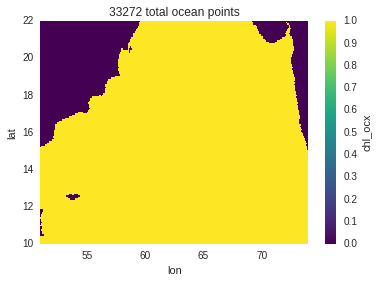

In [7]:
#  find a mask for the land
ocean_mask = (ds_8day.chl_ocx>0).sum(dim='time')>0
num_ocean_points = ocean_mask.sum().values
ocean_mask.plot()
plt.title('%g total ocean points' % num_ocean_points)

Now we count up the number of valid points in each snapshot and divide by the total number of ocean points.

In [8]:
count_8day, coundt_daily = [ds.chl_ocx.groupby('time').count()/float(num_ocean_points)
                            for ds in ds_8day, ds_daily]

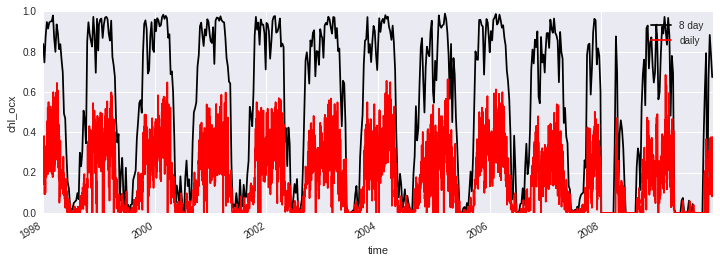

In [9]:
plt.figure(figsize=(12,4))
count_8day.plot(color='k')
coundt_daily.plot(color='r')
plt.legend(['8 day', 'daily'])

## Seasonal Climatology

In [10]:
count_8day_clim, coundt_daily_clim = [count.groupby('time.month').mean()
                                      for count in count_8day, coundt_daily]

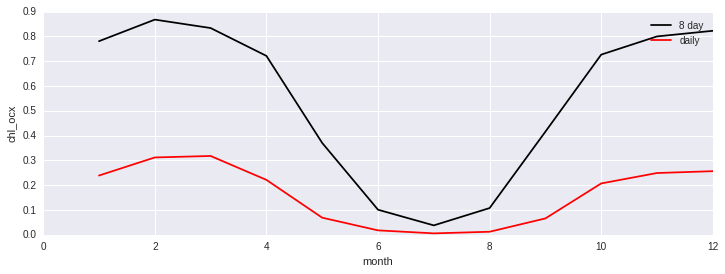

In [11]:
plt.figure(figsize=(12,4))
count_8day_clim.plot(color='k')
coundt_daily_clim.plot(color='r')
plt.legend(['8 day', 'daily'])

From the above figure, we see that data coverage is highest in the winter (especially Feburary) and lowest in summer.

## Maps of individual days

Let's grab some data from Febrauary and plot it.

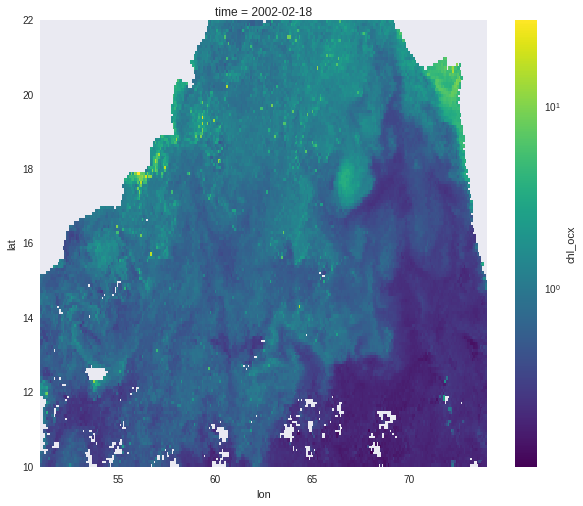

In [12]:
target_date = '2002-02-15'
plt.figure(figsize=(10,8))
ds_8day.chl_ocx.sel(time=target_date, method='nearest').plot(norm=LogNorm())

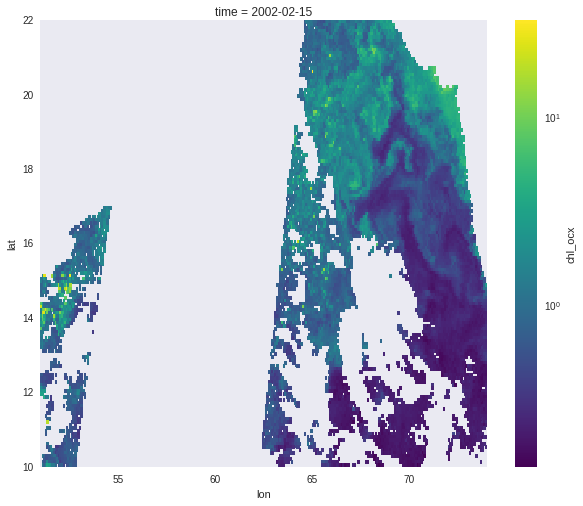

In [13]:
plt.figure(figsize=(10,8))
ds_daily.chl_ocx.sel(time=target_date, method='nearest').plot(norm=LogNorm())